# Notebook 2:  Binary Classification
__Author: Bibek Poudel__

Using the results from Cross Validation (Notebook 1), I train the neural networks on the entire training dataset and see thier test performance here 

In [1]:
import time
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import random
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
%matplotlib inline

In [2]:
# set seeds for reproducibility of results
SEED = 99
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# Define a dataset class (Required by pytorch)
class BinaryDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs_list = inputs
        self.target_list = targets
        assert (len(self.inputs_list) == len(self.target_list))
        
    def __len__(self):
        return len(self.inputs_list)
    
    def __getitem__(self, key):
        input_idx = self.inputs_list[key]
        target_idx = self.target_list[key]
        return [input_idx.astype(np.float32), target_idx.astype(np.float32)]

In [4]:
# Define a neural network with a single hidden layer
class model(nn.Module):
    def __init__(self, input_units, hidden_units):
        super().__init__()
        self.activation = nn.ReLU() # ReLU activation function
        self.fc1 = nn.Linear(input_units, hidden_units) # Hidden units can be specified arbitrarily
        self.fc2 = nn.Linear(hidden_units, 1)
        self.output_activation = nn.Sigmoid()
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.output_activation(self.fc2(x)) # For Binary classification
        return x

In [5]:
# Define a performance metric
def akkuracy(ground_truths, predictions):
    
    predictions = torch.Tensor(predictions)
    ground_truths = torch.ByteTensor(ground_truths)   # a Tensor of 0s and 1s
    actual_preds = predictions >= 0.5       # a Tensor of 0s and 1s or True and False
    num_correct = torch.sum(ground_truths==actual_preds)  # a Tensor
    acc = (num_correct.item() * 100.0 / len(ground_truths))  # scalar
    return acc

In [6]:
# Define a method to train neural network model
def train(model, dataloader, optimizer, learning_rate, loss_function, epochs, train_size):
    
    epoch_losses = np.zeros(epochs)
    for epoch in range(epochs):
        predictions =  np.zeros(train_size)
        ground_truths_total= np.zeros(train_size)
        count =0
        
        #print("Epoch:{}".format(epoch), end = "\t")
        total_loss = 0.0

        for bi, (inputs, targets) in enumerate(dataloader):
            current_size=targets.shape[0]
            ground_truths_total[count: count+current_size] = targets
            
            targets= targets.view(-1,1) # or do torch squeeze to outputs
            optimizer.zero_grad()

            outputs = model(inputs)
            outputs_np = np.squeeze(outputs.cpu().detach().numpy())
            
            loss = loss_function(outputs, targets)

            loss.backward()

            optimizer.step()
            
            total_loss+=loss.item()
            
            
            predictions[count: count+current_size] = outputs_np
            count+=current_size
        avg_batch_loss = round(total_loss/len(dataloader),3)
        #print("Average batch loss:{}".format(avg_batch_loss))
        epoch_losses[epoch] = avg_batch_loss
        torch.save(model, "./saved_models/training_model.pt")
        train_accuracy = akkuracy(ground_truths_total, predictions)
    
    return epoch_losses, train_accuracy

In [7]:
# Define a method to perform model validation
def test(trained_model, dataloader, test_size):
    predictions =  np.zeros(test_size)
    ground_truths_total= np.zeros(test_size)
    count =0
    with torch.no_grad():
        for bi, (inputs, ground_truths) in enumerate(dataloader):
            
            outputs = trained_model(inputs)
            outputs_np = np.squeeze(outputs.cpu().detach().numpy()) #Although ... 

            current_size=ground_truths.shape[0]
            predictions[count: count+current_size] = outputs_np
            ground_truths_total[count: count+current_size] = ground_truths#.cpu().detach().numpy()
            count+=current_size

    test_accuracy = akkuracy(ground_truths_total, predictions)
    return test_accuracy, predictions, ground_truths_total

In [8]:
# Results from Corss Validation
cv_results = {'iris.npz': 9, 'digit.npz':9,  'breast-cancer.npz':10, 'wine.npz': 7, 'diabetes.npz':8 }
datasets = glob.glob('./datasets/bi-class/*.npz')


__________________________________________________________

For iris.npz dataset,
Training time = 
Training accuracy at last epoch = 100.0%:


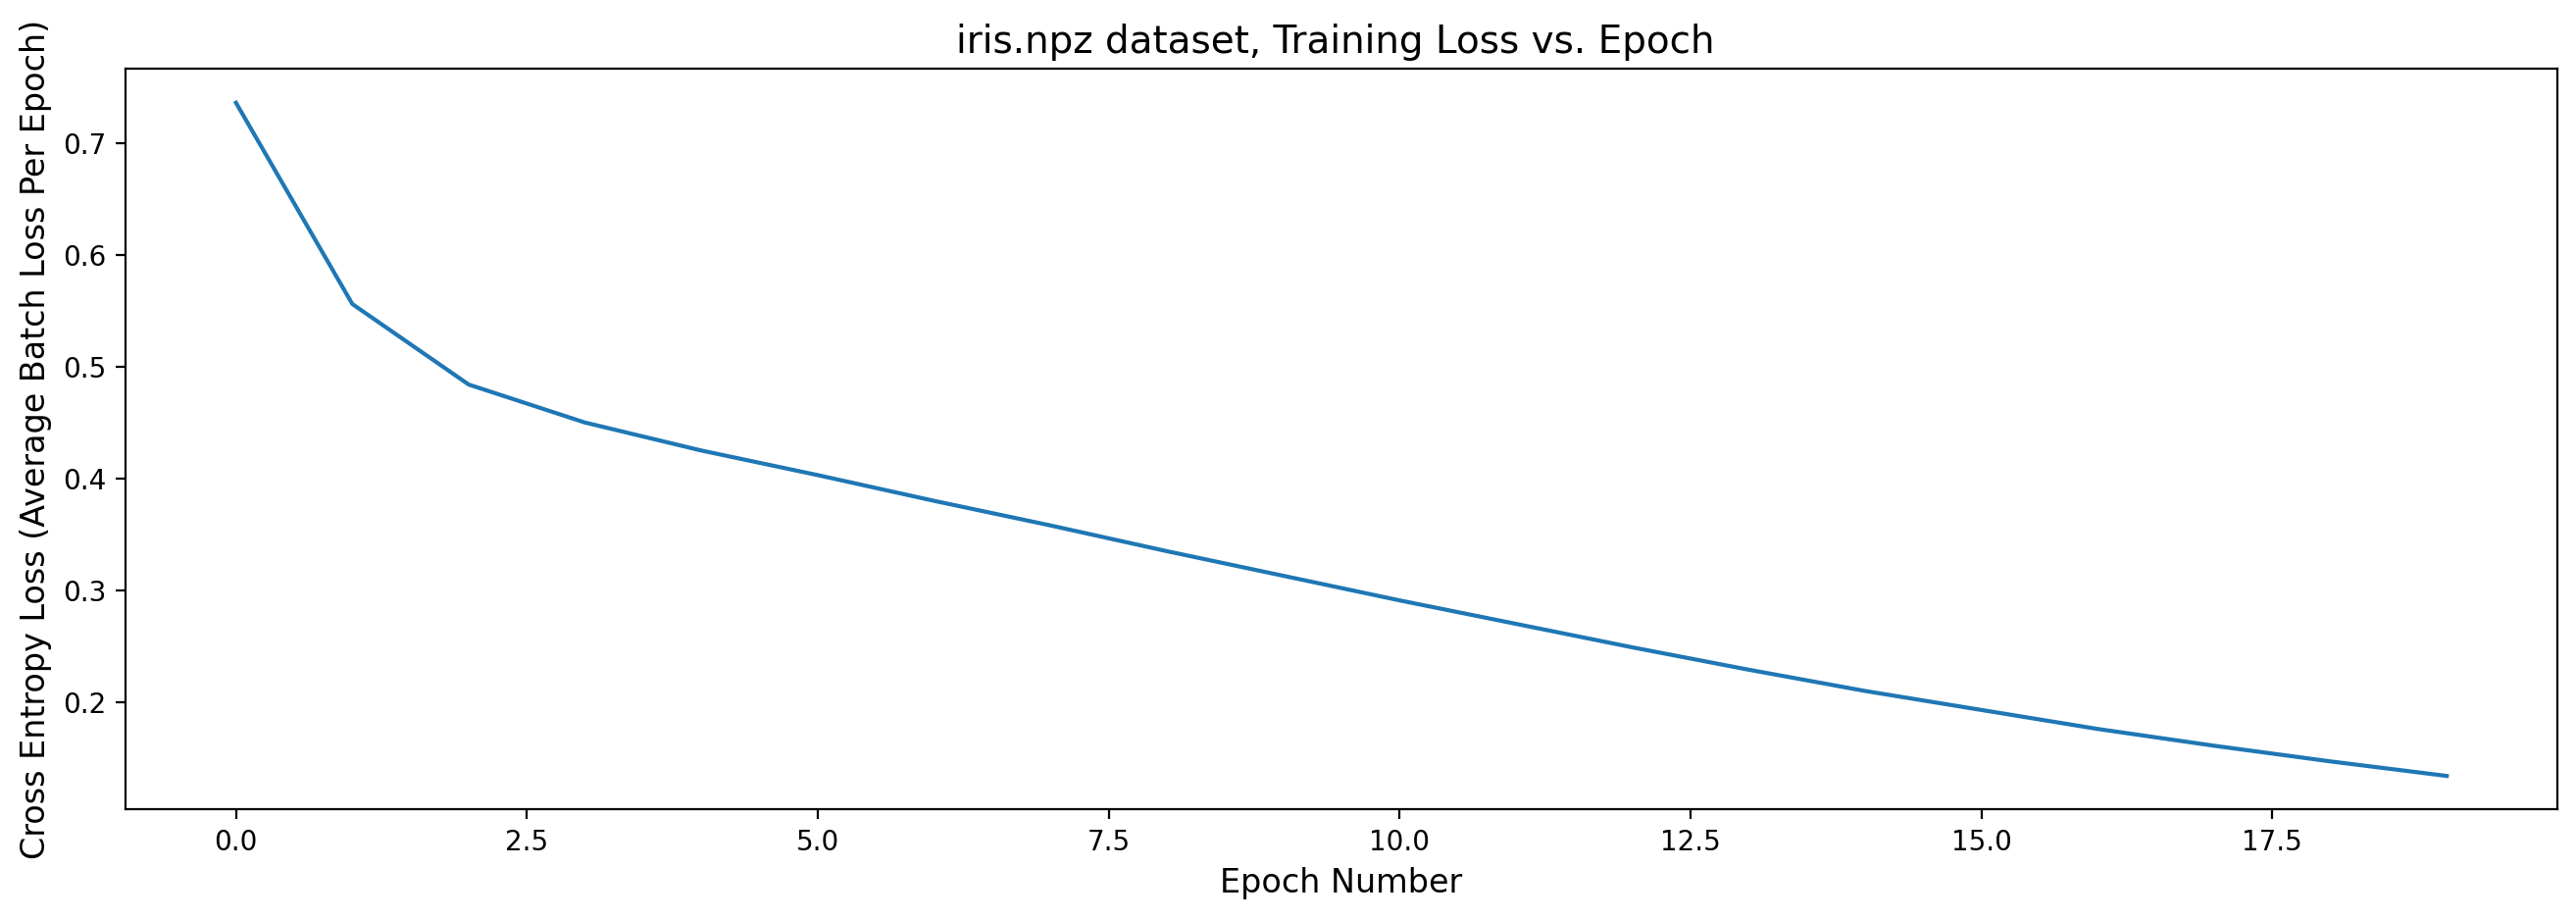


__________________________________________________________
Test accuracy = 100.0 %
Confusion Matrix:


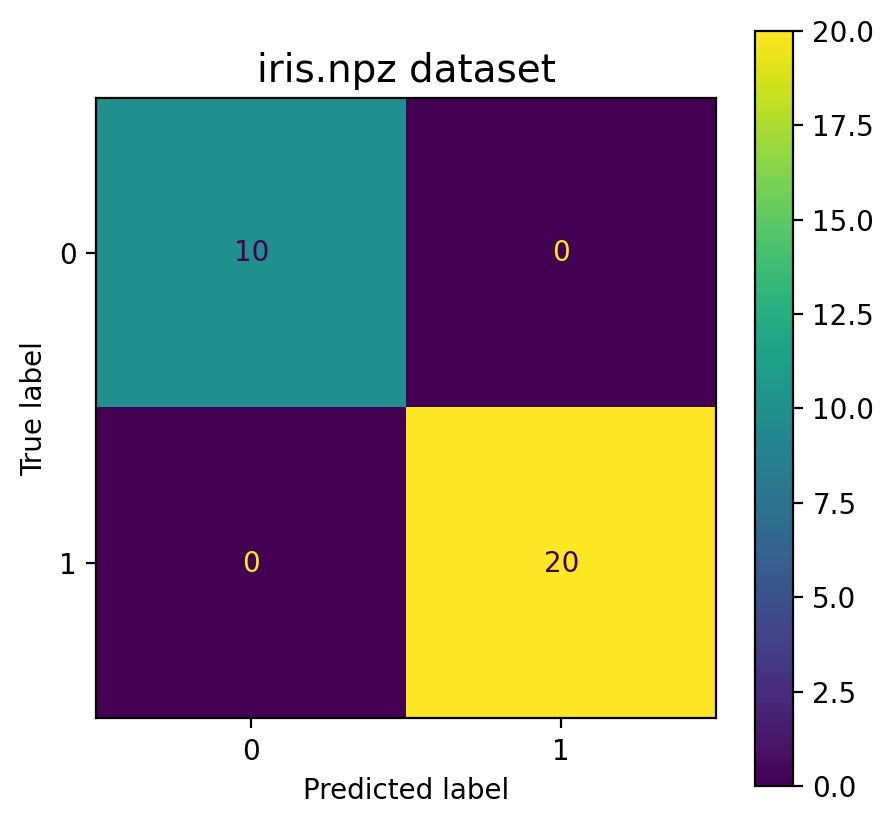


__________________________________________________________

For digit.npz dataset,
Training time = 
Training accuracy at last epoch = 99.375%:


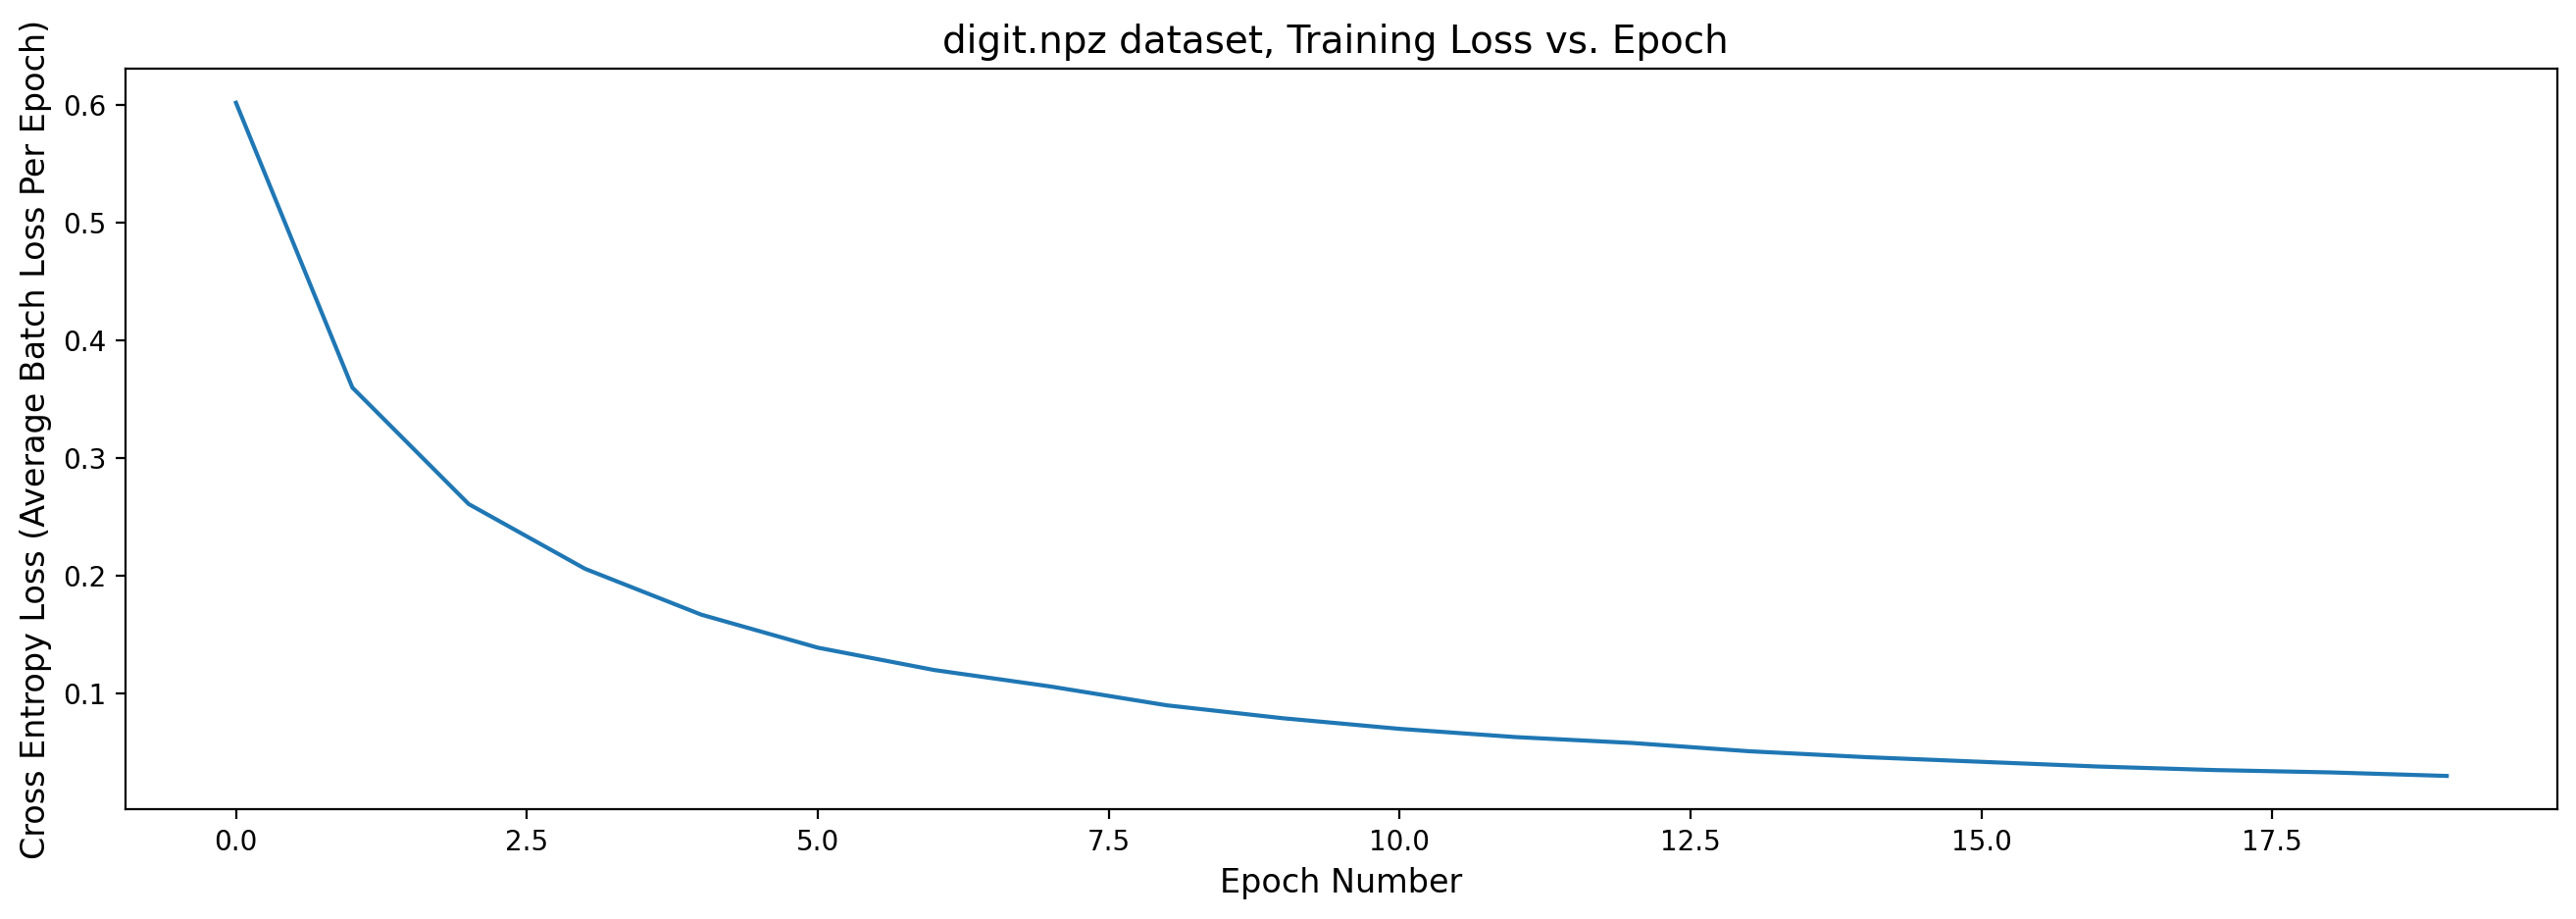


__________________________________________________________
Test accuracy = 98.0 %
Confusion Matrix:


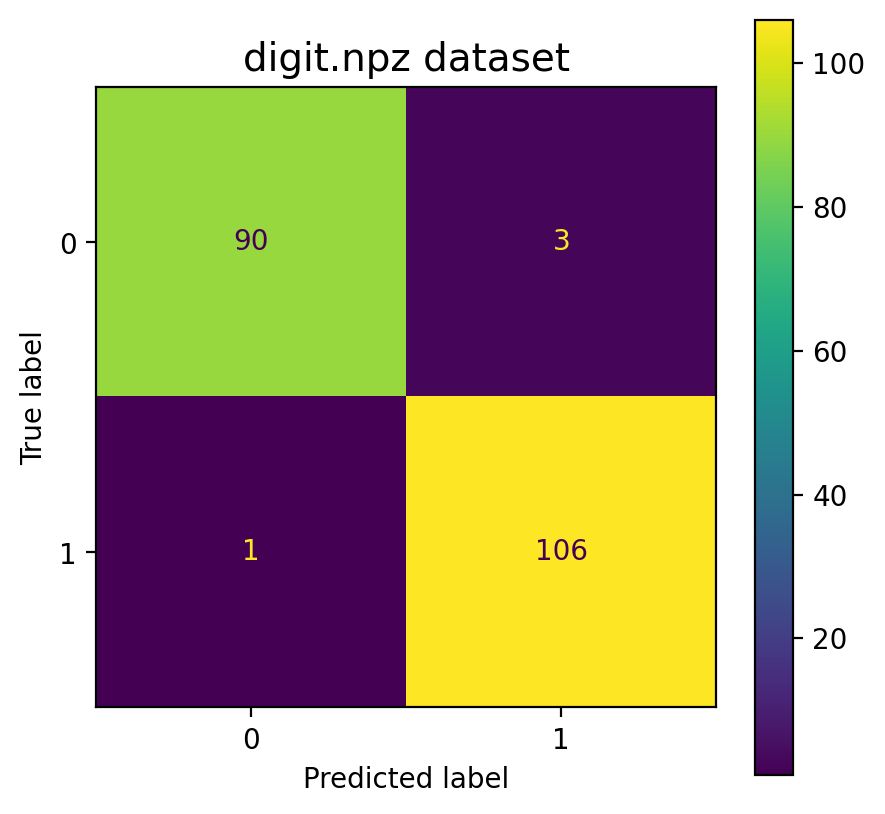


__________________________________________________________

For breast-cancer.npz dataset,
Training time = 
Training accuracy at last epoch = 97.075%:


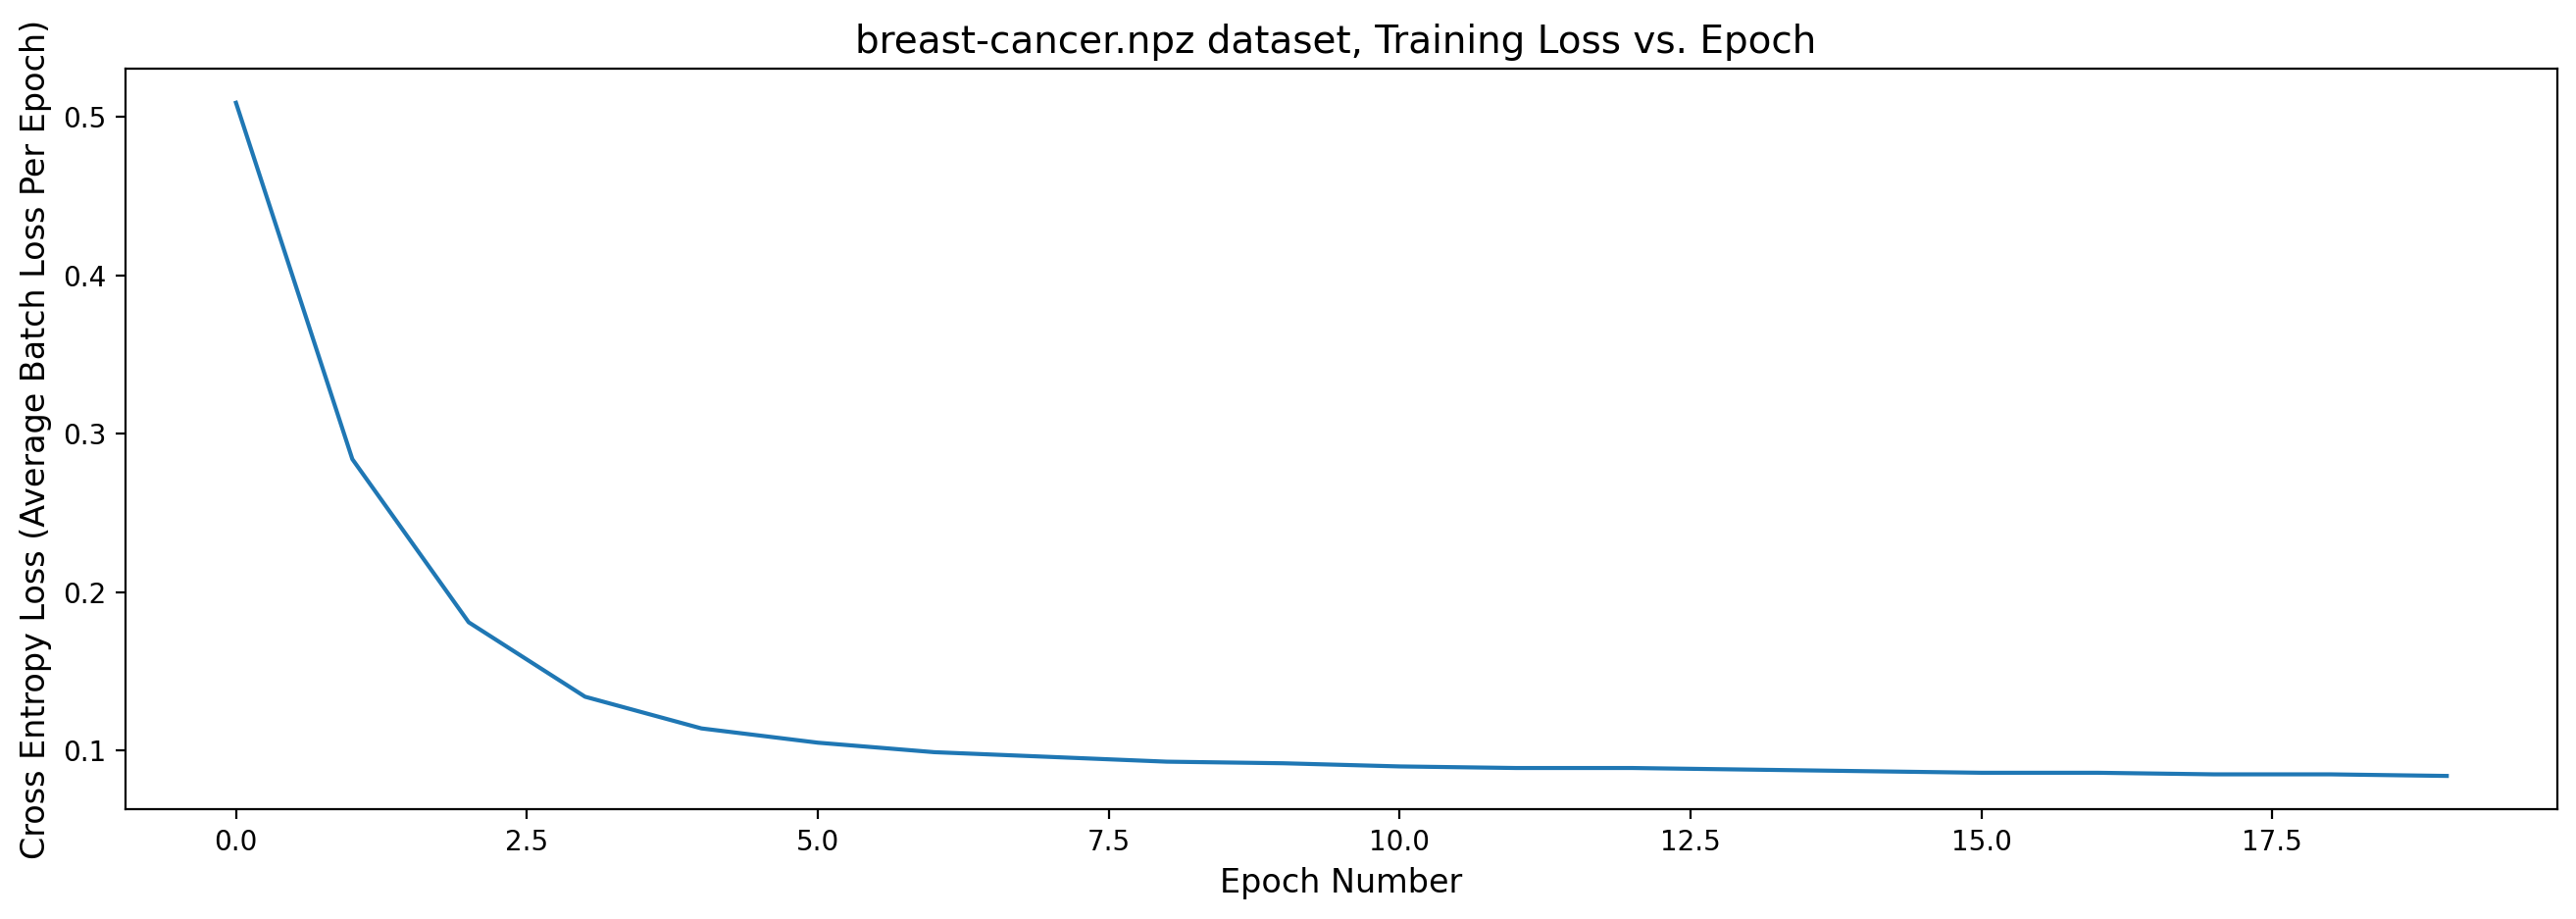


__________________________________________________________
Test accuracy = 95.588 %
Confusion Matrix:


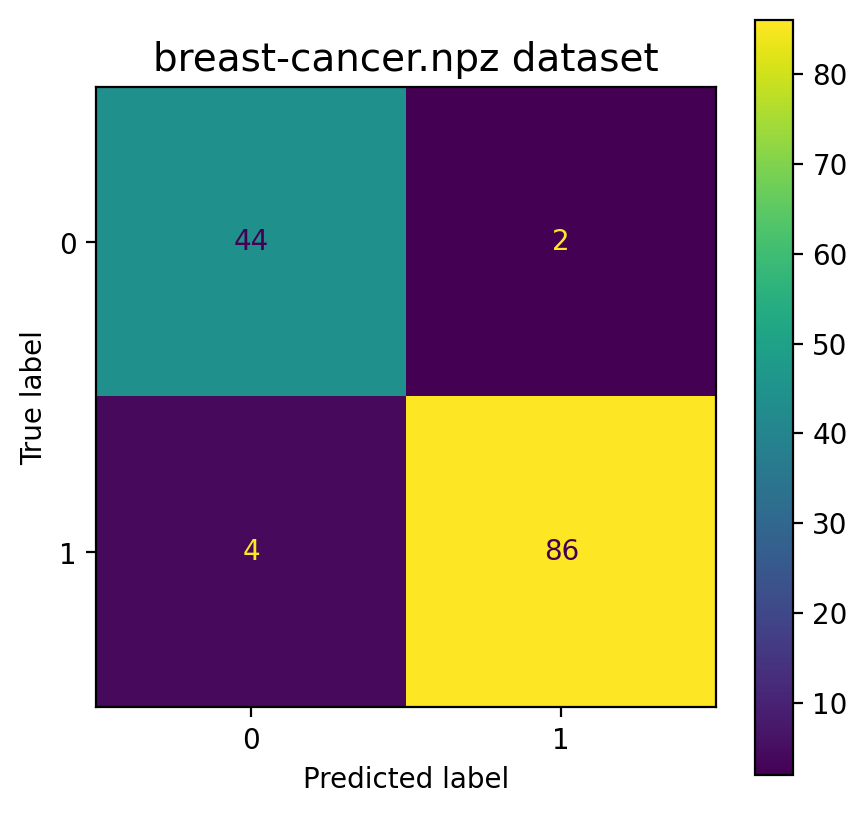


__________________________________________________________

For wine.npz dataset,
Training time = 
Training accuracy at last epoch = 82.394%:


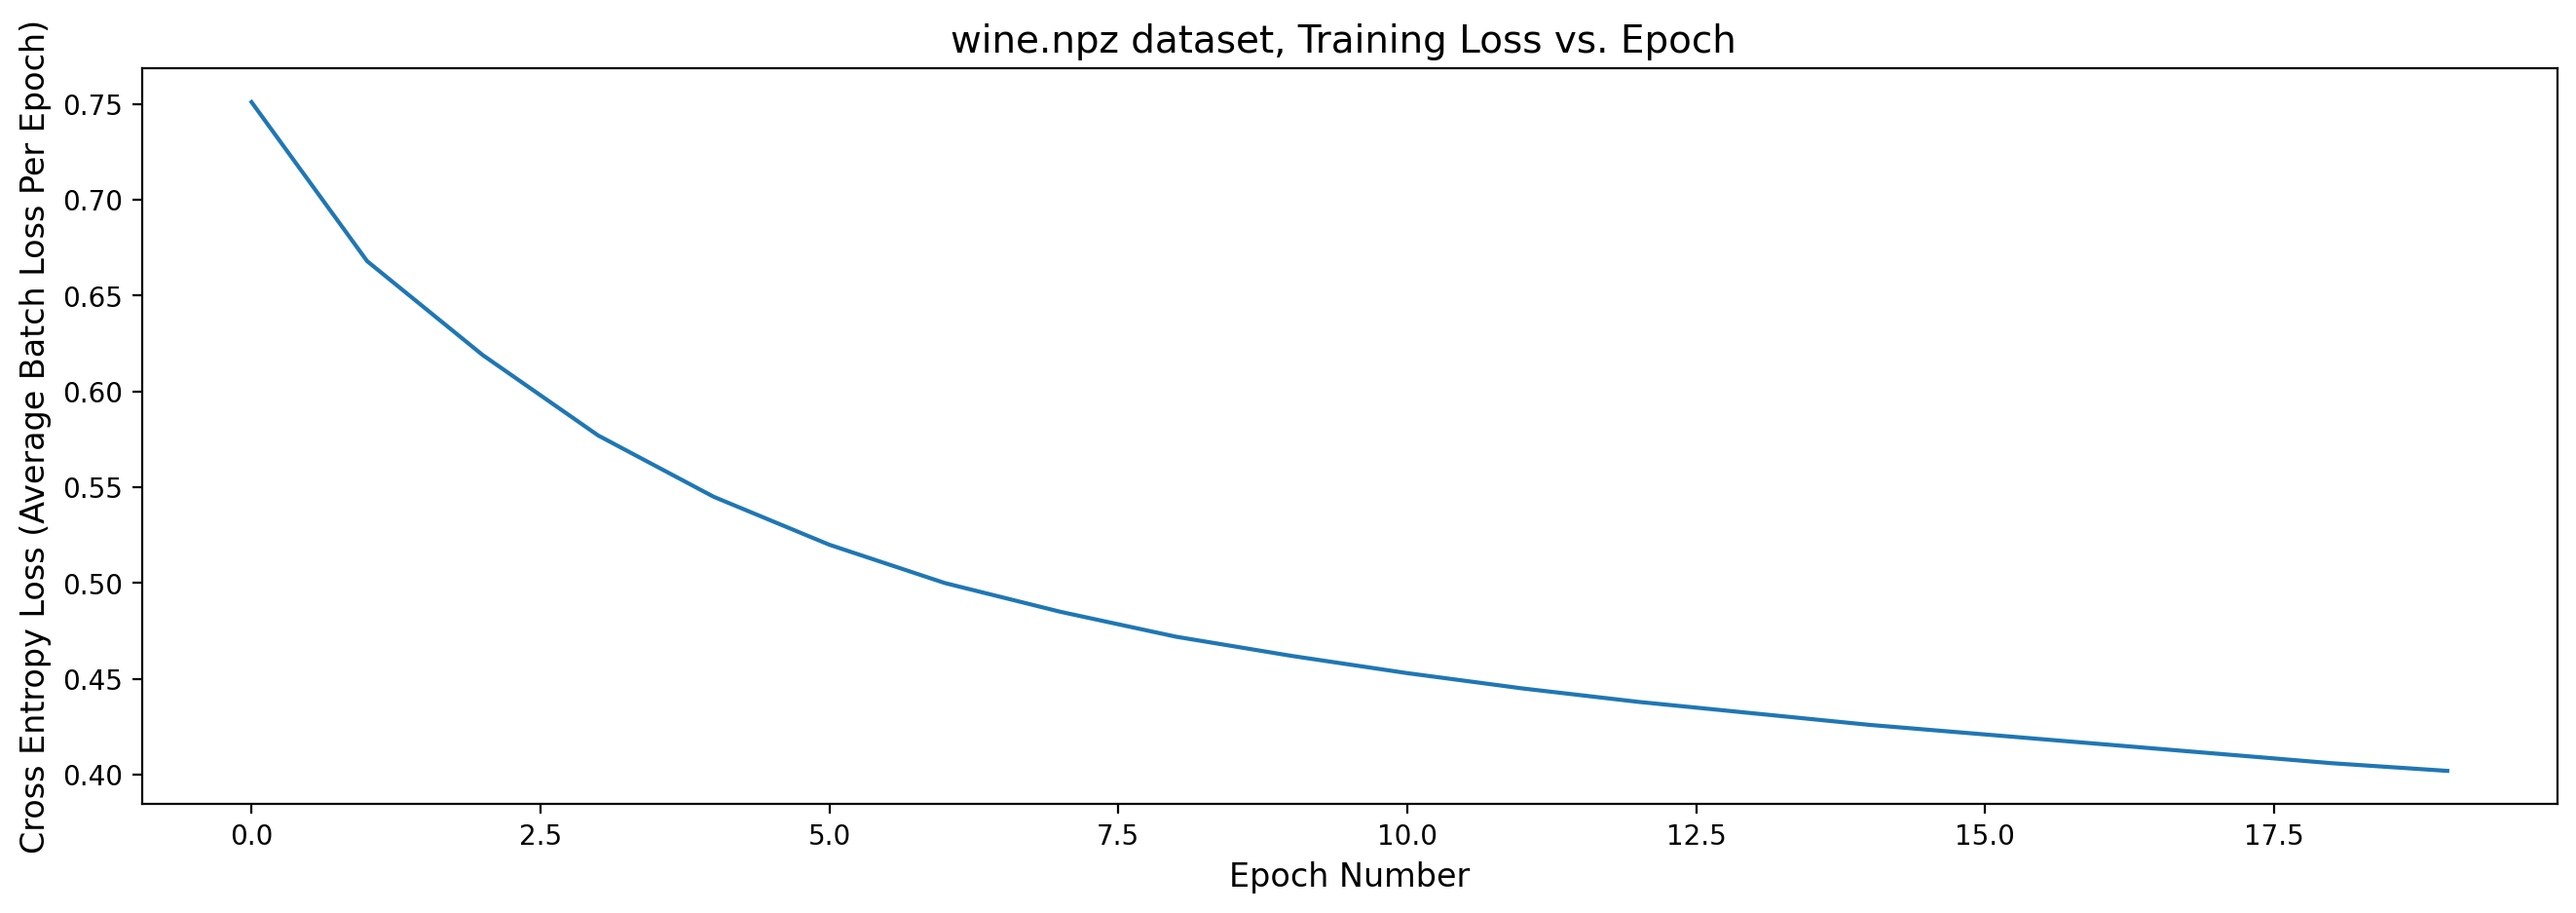


__________________________________________________________
Test accuracy = 80.556 %
Confusion Matrix:


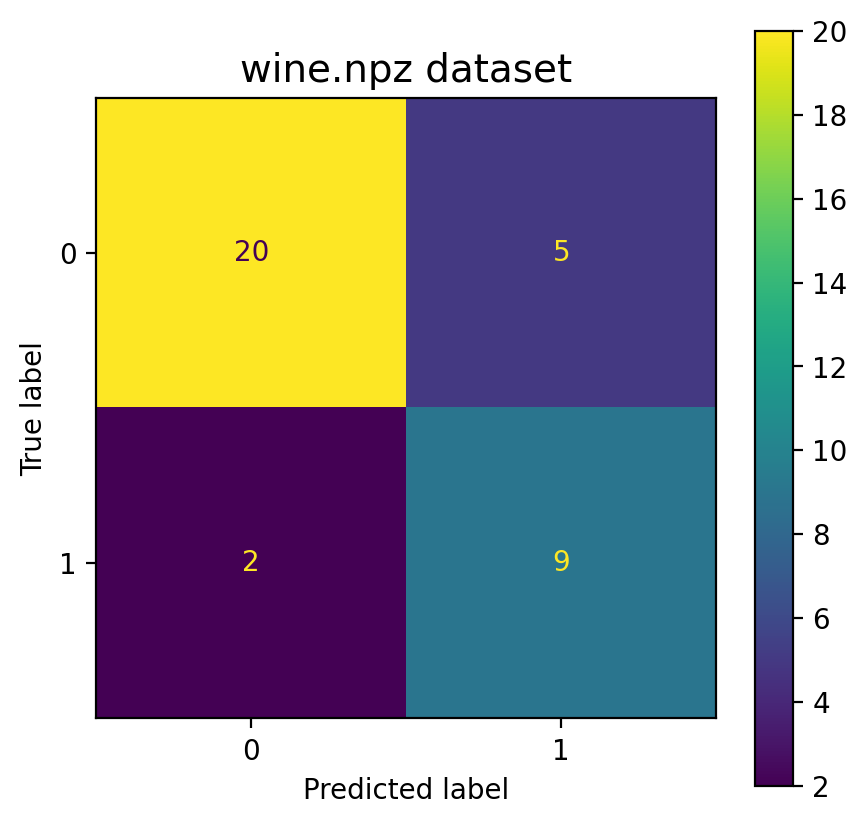


__________________________________________________________

For diabetes.npz dataset,
Training time = 
Training accuracy at last epoch = 76.585%:


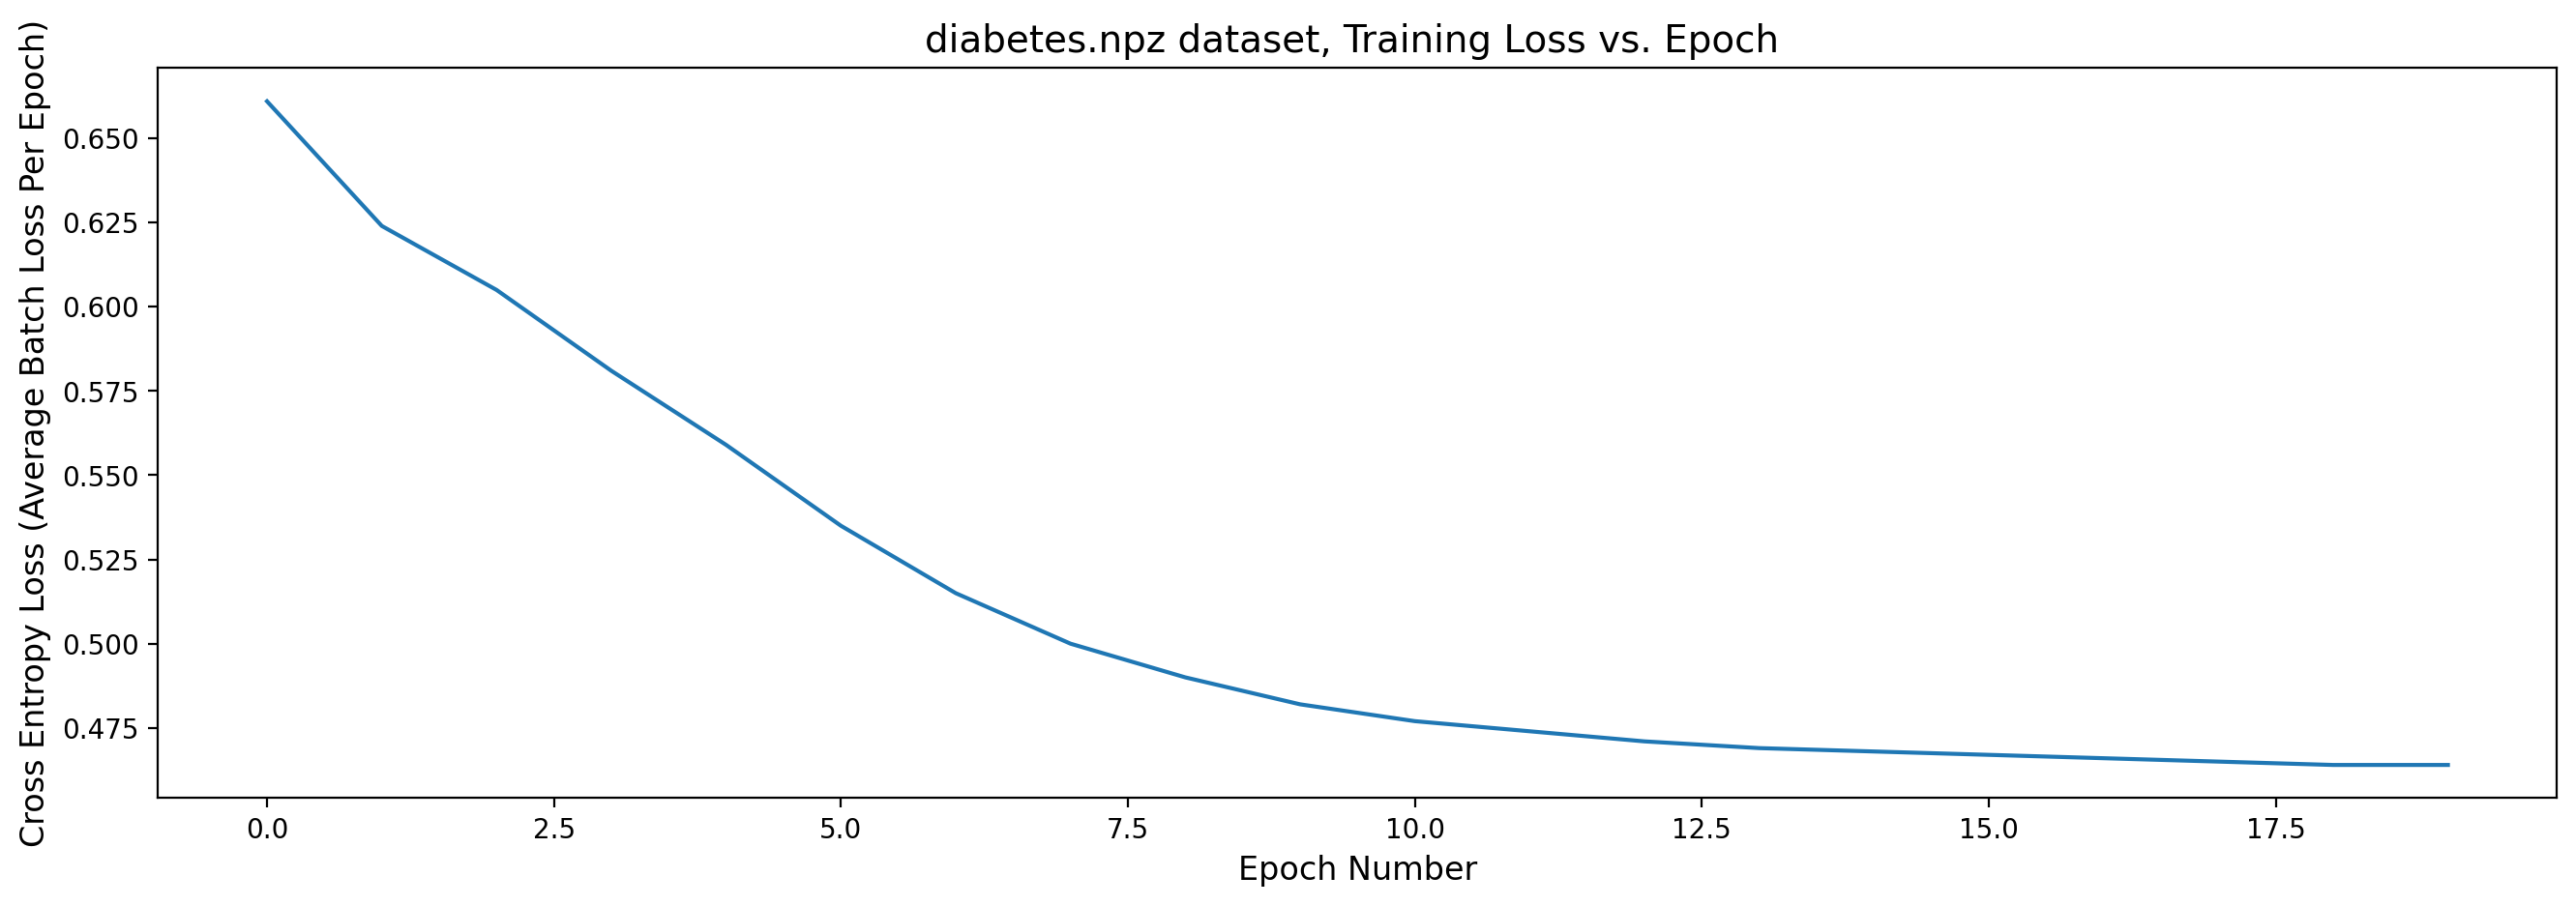


__________________________________________________________
Test accuracy = 78.431 %
Confusion Matrix:


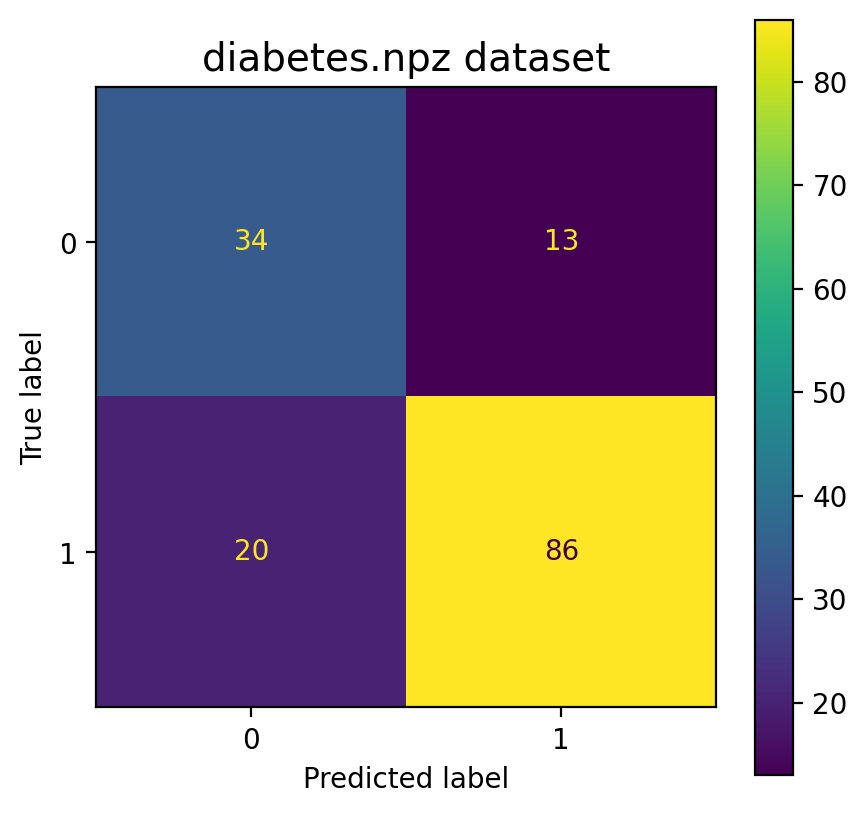


__________________________________________________________


In [9]:
for dataset_path in datasets:
    results=[]
    print("\n__________________________________________________________")
    name = dataset_path.split('/')[-1]
    print("\nFor {} dataset,".format(name))
    
    hidden_units = cv_results[name]
    
    dataset = np.load(dataset_path)
    train_X, train_Y, test_X, test_Y = dataset['train_X'],dataset['train_Y'],dataset['test_X'],dataset['test_Y']
    
    net = model(train_X.shape[1], hidden_units).train()
    
    # Using some standard hyper-parameter values 
    epochs =20
    loss = nn.BCELoss() # Loss function as Binary Cross Entropy
    lr = 0.001 # Learning rate 
    optimizer = torch.optim.Adam(net.parameters(), lr = lr) # Optimizer as Adam
    BATCH_SIZE = 4
    
    train_dataset = BinaryDataset(train_X, train_Y)
    test_dataset = BinaryDataset(test_X, test_Y)
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=None,
                                                   shuffle=False)
    test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=None,
                                                   shuffle=False)
    start = time.time()
    train_loss, train_acc = train(net, train_dataloader, optimizer, lr, loss, epochs, train_Y.shape[0])
    print("Training time = ")
    print("Training accuracy at last epoch = {}%:".format(round(train_acc,3)))
    # Plot the training profile
    fig, ax = plt.subplots(figsize=(16,5), dpi =200)
    ax.plot(train_loss)
    ax.set_title("{} dataset, Training Loss vs. Epoch ".format(name), fontsize=14)
    ax.set_ylabel("Cross Entropy Loss (Average Batch Loss Per Epoch)", fontsize=12)
    ax.set_xlabel("Epoch Number", fontsize=12)
    plt.show()
    print("\n__________________________________________________________")

    trained_model = torch.load("./saved_models/training_model.pt")
    test_acc, preds, gts = test(trained_model, test_dataloader, test_Y.shape[0])
    preds = [1 if pred>=0.5 else 0 for pred in preds]

    print("Test accuracy = {} %".format(round(test_acc,3)))
    print("Confusion Matrix:")
    fig_2,ax_2 = plt.subplots(figsize=(5,5), dpi=200)
    ax_2.set_title("{} dataset".format(name), fontsize=14)
    ConfusionMatrixDisplay.from_predictions(preds,gts, ax=ax_2) #gts, preds
    plt.show()
print("\n__________________________________________________________")